This workbook is EDA for the data from https://data.medicare.gov/

The two primary datasets are:

    1)  Complications and Deaths - Hospital
        Availible at: 
        https://data.medicare.gov/Hospital-Compare/Complications-and-Deaths-Hospital/ynj2-r877
        
    2) Patient survey (HCAHPS) - Hospital
        Dataset 2 must be downloaded manually from the archive files as: 
        'HOSArchive_Revised_FlatFiles_20160504/HCAHPS - Hospital.csv'

The goal of the modeling is to associate current period survey results on hospital care with mortality outcomes in the coming years. Past research from 2014 has found that "Low mortality index was consistently found to be associated with high satisfaction across 9 of 10 HCAHPS domains."[1] This suggests that it is worthwhile to include this data in our app and try and pick up trends in satisfaction that might indicate changes in mortality rates by hospital in the future. 


[1] https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4159721/




In [311]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from sklego.pandas_utils import log_step
import pydotplus
import seaborn as sns
from pandas_profiling import ProfileReport
import os
os.environ["PATH"] += os.pathsep + 'D:/Program Files (x86)/Graphviz2.38/bin/'

In [314]:
## This imports all 155 current datasets

In [290]:
directory = '/Users/matthewloskamp/Dropbox/MSPA/Final/pickle_data'
## read all data from disk
files = os.listdir(directory)
dict_of_df = {}
for f in files:
    ## load dfs and use id as key
    dict_of_df[f[0:9]] = pd.read_pickle(directory + "/{0}".format(f))

In [12]:
len(dict_of_df.keys())

155

In [15]:
directory = '/Users/matthewloskamp/Dropbox/MSPA/Final/Project Data/'
file = 'HOSArchive_Revised_FlatFiles_20160504/HCAHPS - Hospital.csv'
old_survey = pd.read_csv(directory + file, engine = 'python')

In [115]:
old_survey.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255365 entries, 0 to 255364
Data columns (total 22 columns):
 #   Column                                 Non-Null Count   Dtype 
---  ------                                 --------------   ----- 
 0   Provider ID                            255365 non-null  int64 
 1   Hospital Name                          255365 non-null  object
 2   Address                                255365 non-null  object
 3   City                                   255365 non-null  object
 4   State                                  255365 non-null  object
 5   ZIP Code                               255365 non-null  int64 
 6   County Name                            254650 non-null  object
 7   Phone Number                           255365 non-null  int64 
 8   HCAHPS Measure ID                      255365 non-null  object
 9   HCAHPS Question                        255365 non-null  object
 10  HCAHPS Answer Description              255365 non-null  object
 11  

In [315]:
## this is the Complications and Deaths - Hospital data
deaths = dict_of_df['ynj2-r877']

In [199]:
## This transforms the Complications and Deaths - Hospital into a wide format
## pk = provider id
## Drops VA hospitals as they are not in the historical survey data for some reason
deaths = deaths[~deaths['provider_id'].str.contains("F")]
deaths_wide = deaths.pivot(index='provider_id', columns='measure_id', values = 'compared_to_national').reset_index()
deaths_wide.columns.name = None ## this drops a multi-index that gets created

In [149]:
## This transforms the survey data from the period prior to the deaths dataset into a
## wide format that can be used in models
## pk = Provider ID
survey_wide = old_survey.pivot(index='Provider ID', columns='HCAHPS Measure ID', values = 'HCAHPS Answer Percent').reset_index()
survey_wide.columns.name = None ## this drops an multi-index that gets created by the pivot 
survey_wide = survey_wide.astype({'Provider ID':'int32'})

## This filters to only the survey questions
## The values for these other features (STAR/SCORE) are saved in different column
keep_cols = [col for col in survey_wide.columns if 'STAR_RATING' not in col]
keep_cols = [col for col in keep_cols if 'SCORE' not in col]
survey_wide = survey_wide[keep_cols]
#survey_wide.head(1).T

In [201]:
## might get used at some point
star_ratings = old_survey.pivot(index='Provider ID', columns='HCAHPS Measure ID', values = 'Patient Survey Star Rating').reset_index()
star_ratings.columns.name = None
keep_cols = [col for col in star_ratings.columns if 'STAR_RATING' in col]
star_ratings = star_ratings[keep_cols]
#star_ratings.head(1).T

In [140]:
## focus on a single death type to start MORT_30_HF
target_df = deaths_wide[['provider_id','MORT_30_HF']]
target_df = target_df.astype({'provider_id':'int32'})

In [242]:
## join tables and keep only complete records and those that have enough cases
train = target_df.merge(survey_wide, left_on='provider_id', right_on='Provider ID', how = 'inner')
train = train.replace('Not Available', np.nan)
train = train.replace('Number of Cases Too Small', np.nan)
train = train.dropna()

In [243]:
## all columns other than these should be numeric
numeric_cols = [col for col in train.columns if col not in ['provider_id','MORT_30_HF','Provider ID']]
train[numeric_cols] = train[numeric_cols].apply(pd.to_numeric) 

In [244]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3315 entries, 0 to 4430
Data columns (total 35 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   provider_id        3315 non-null   int32 
 1   MORT_30_HF         3315 non-null   object
 2   Provider ID        3315 non-null   int32 
 3   H_CLEAN_HSP_A_P    3315 non-null   int64 
 4   H_CLEAN_HSP_SN_P   3315 non-null   int64 
 5   H_CLEAN_HSP_U_P    3315 non-null   int64 
 6   H_COMP_1_A_P       3315 non-null   int64 
 7   H_COMP_1_SN_P      3315 non-null   int64 
 8   H_COMP_1_U_P       3315 non-null   int64 
 9   H_COMP_2_A_P       3315 non-null   int64 
 10  H_COMP_2_SN_P      3315 non-null   int64 
 11  H_COMP_2_U_P       3315 non-null   int64 
 12  H_COMP_3_A_P       3315 non-null   int64 
 13  H_COMP_3_SN_P      3315 non-null   int64 
 14  H_COMP_3_U_P       3315 non-null   int64 
 15  H_COMP_4_A_P       3315 non-null   int64 
 16  H_COMP_4_SN_P      3315 non-null   int64 


In [246]:
## decision tree to understand basic relationships
from sklearn import tree
X = train[numeric_cols]
y = train['MORT_30_HF']
clf = tree.DecisionTreeClassifier(max_depth = 3)
clf = clf.fit(X, y)

In [274]:
names_for_plot = train.groupby(['MORT_30_HF'])['provider_id'].count().sort_values().index

In [283]:
names_for_plot = ['Better Than the National Rate','No Different Than the National Rate','Worse Than the National Rate']

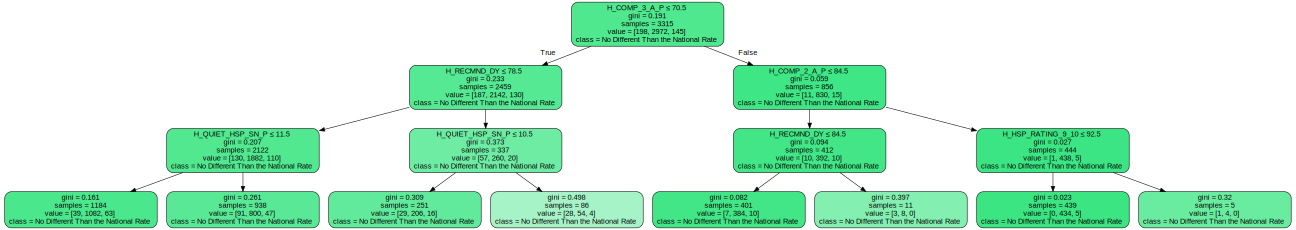

In [318]:
dot_data = tree.export_graphviz(clf
                                , out_file=None
                                , filled=True
                                , feature_names= numeric_cols
                                , class_names= names_for_plot
                                , rounded=True
                                , special_characters=True                               
                               )
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.set_size('"18,25!"')
graph = graphviz.Source(pydot_graph.to_string())
graph 

In [306]:
profile = ProfileReport(train, title="Pandas Profiling Report")
profile.to_notebook_iframe()

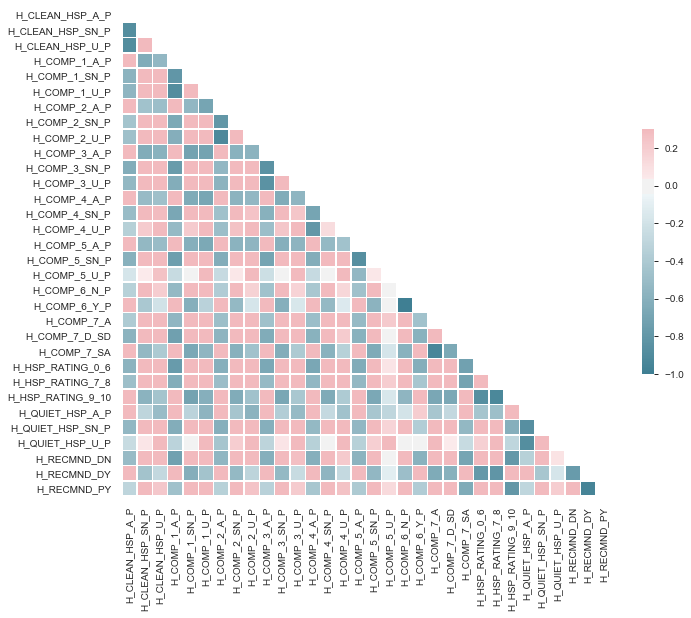

In [312]:
# Compute the correlation matrix
corr = train[numeric_cols].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})